# Kaggle Setup

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tbierhance/hm-fashion-recommendation-parquet
! kaggle datasets download -d tbierhance/hm-fashion-images-squared-224/images_224x224

 98% 240M/244M [00:08<00:00, 35.9MB/s]
100% 244M/244M [00:09<00:00, 28.3MB/s]
 98% 268M/272M [00:09<00:00, 19.7MB/s]
100% 272M/272M [00:09<00:00, 29.4MB/s]


In [ ]:
!unzip hm-fashion-recommendation-parquet.zip
!unzip hm-fashion-images-squared-224.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_224x224/089/0890631005.jpg  
  inflating: images_224x224/089/0890639001.jpg  
  inflating: images_224x224/089/0890639002.jpg  
  inflating: images_224x224/089/0890677001.jpg  
  inflating: images_224x224/089/0890677002.jpg  
  inflating: images_224x224/089/0890677004.jpg  
  inflating: images_224x224/089/0890683001.jpg  
  inflating: images_224x224/089/0890683002.jpg  
  inflating: images_224x224/089/0890684001.jpg  
  inflating: images_224x224/089/0890684002.jpg  
  inflating: images_224x224/089/0890686002.jpg  
  inflating: images_224x224/089/0890697001.jpg  
  inflating: images_224x224/089/0890697002.jpg  
  inflating: images_224x224/089/0890700001.jpg  
  inflating: images_224x224/089/0890717001.jpg  
  inflating: images_224x224/089/0890717002.jpg  
  inflating: images_224x224/089/0890717003.jpg  
  inflating: images_224x224/089/0890722001.jpg  
  inflating: images_224x224/089/0890722002.jpg  
  inflating: image

# Data Upload and Image Process

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.notebook import tqdm

from PIL import Image
import math
import os

In [ ]:
articles = pd.read_parquet('articles.parquet')
sales = pd.read_parquet('sales.parquet')
customers = pd.read_parquet('customers.parquet')

In [ ]:
# get the image path for articles

def image_path_for_article(article_id):
    id = f'{article_id:010d}'
    return(f'images_224x224/{id[:3]}/{id}.jpg')

In [ ]:
def create_image_grid(image_paths, size=150, max_cols=5, background_color=(255, 255, 255)):
    image_count = len(image_paths)
    cols = min(max_cols, image_count)
    rows = 0 if cols == 0 else math.ceil(image_count/cols)

    result_image = Image.new('RGB', (cols*size, rows*size), color=background_color)
    for idx, image_path in enumerate(image_paths):
        image = Image.open(image_path).resize((size, size)) if image_path!='' else Image.new('RGB', (size, size))
        (row, col) = divmod(idx, max_cols)
        result_image.paste(image, (col*size, row*size))
    return(result_image)

In [ ]:
def show_articles(article_id, size=150, max_cols=5):
    if hasattr(article_id, '__iter__'):
        image_paths = [image_path_for_article(id) for id in article_id]
        image_paths = [image_path if os.path.isfile(image_path) else '' for image_path in image_paths]                
        return(create_image_grid(image_paths, size, max_cols))
    else:
        return Image.open(image_path_for_article(article_id)).resize((size, size))

In [ ]:
# get the list of articles
def get_articles(article_id):
  return([image_path_for_article(id) for id in article_id])

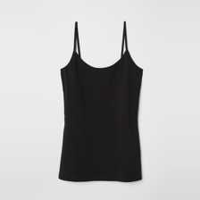

In [ ]:
show_articles(108775015, size=200)

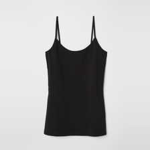

In [ ]:
# article_ids = customers[customers.age.between(40, 50)].merge(sales).groupby('article_id').size().nlargest(20).index
online_sales = sales[sales['online_channel']==True]
article_ids = online_sales[online_sales.week.between(84,92)].groupby('article_id').size().index # get the list of article_ids between week 92 and 93.
# size = online_sales[online_sales.week.between(92,93)].groupby('article_id').size()
# print(size)
# get the train set
images = get_articles(article_ids) # size is 18404 / if we change the week to 84-92, size is 25610

# check on images corresponding to each article id
show_articles(article_ids[0], size=150)

In [ ]:
len(article_ids)

25610

### articles deletion whose with no images

Since there are some articles listed out contain no images, we will delete those article ids

In [ ]:
# find index values of articles with no images related
idx = []
for i in range(25610): #26495):
  image_name = [] 
  id = f'{article_ids[i]:010d}'
  list_ids = os.listdir(f'images_224x224/{id[:3]}')
  # print(list_ids)
  for j in range(len(list_ids)):
    image_name.append(f'images_224x224/{id[:3]}/{list_ids[j]}')

  # to compare with the given image
  check = [im for im in image_name if(im in images[i])] # need to bool(check) to have true/false
  if bool(check) == False:
    idx.append(i)
  # print(f'{i}: {bool(check)}')

##########
# delete the non-image-related articles
images = [i for j, i in enumerate(images) if j not in idx]

print(len(images))

25565


# CNN on selected images

In [ ]:
# Set up, use cv2
!pip install opencv-python
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2

import torch
from torch import optim, nn
from torchvision import models, transforms
model = models.vgg16(pretrained=True)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 

# Initialize the model
model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [ ]:
# from google.colab.patches import cv2_imshow
from tqdm import tqdm, trange

In [ ]:
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(256),
  transforms.Resize(224),
  transforms.ToTensor()                              
])

features = []
for i in trange(25565): # size of the images - 31(# of deleted images)
  img = cv2.imread(images[i])
  # print(i)
  img = transform(img)
    
  img = img.reshape(1, 3, 224, 224)
  img = img.to(device)
   
  with torch.no_grad():
    
    feature = new_model(img)
   
  features.append(feature.cpu().detach().numpy().reshape(-1))

# Convert to NumPy Array
features = np.array(features)
print(features.shape)
print(features[0])

from numpy.ma.core import argmin
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Initialize the model
# model = KMeans(n_clusters=6, random_state=42)
# num_clusters = 133
min_num_clusters = 15
max_num_clusters = 50
silhouette_scores = []
davies_bouldin_scores = []
# print("Silhouette Scores")

print("k \t Silhouette \t DB")
for num_clusters in range(min_num_clusters, max_num_clusters):
  print()
  model = KMeans(n_clusters=num_clusters, verbose=1)

  # Fit the data into the model
  model.fit(features)

  # Extract the labels
  labels = model.labels_
  
  # Calculate Silhouette score
  s = metrics.silhouette_score(features, labels, metric='euclidean')
  silhouette_scores.append(s)
  d = metrics.davies_bouldin_score(features, labels)
  davies_bouldin_scores.append(d)
  print(num_clusters, "\t", s, "\t", d)


silhouette_scores = np.array(silhouette_scores)
davies_bouldin_scores = np.array(davies_bouldin_scores)

  0%|          | 30/25565 [00:20<4:53:10,  1.45it/s]


KeyboardInterrupt: ignored

In [ ]:
features.shape

(25565, 4096)

In [ ]:
np.save("/content/drive/MyDrive/cis520-final project/image_vgg_feature.npy",features)

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
features = np.load("/content/drive/MyDrive/CIS520-Final Project/image_vgg_feature.npy")

In [ ]:
from numpy.ma.core import argmin
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Initialize the model
min_num_clusters = 15
max_num_clusters = 50
silhouette_scores = []
davies_bouldin_scores = []
# print("Silhouette Scores")

print("k \t Silhouette \t DB")


k 	 Silhouette 	 DB


In [ ]:
for num_clusters in trange(min_num_clusters, max_num_clusters,2):
  print()
  model = KMeans(n_clusters=num_clusters)

  # Fit the data into the model
  model.fit(features)

  # Extract the labels
  labels = model.labels_
  
  # Calculate Silhouette score
  s = metrics.silhouette_score(features, labels, metric='euclidean')
  silhouette_scores.append(s)
  d = metrics.davies_bouldin_score(features, labels)
  davies_bouldin_scores.append(d)
  print(num_clusters, "\t", s, "\t", d)


silhouette_scores = np.array(silhouette_scores)
davies_bouldin_scores = np.array(davies_bouldin_scores)

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(min_num_clusters, max_num_clusters),verbose=1)

visualizer.fit(features)    # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
best_num_clusters = 32
min_num_clusters = 15
best_num_clusters_index = best_num_clusters - min_num_clusters  

print("Optimal no. of clusters is", best_num_clusters, "by Elbow Method")

Optimal no. of clusters is 32 by Elbow Method


In [ ]:
num_clusters = best_num_clusters
model = KMeans(n_clusters=num_clusters,verbose=1,n_init=5)
y_pred_km = model.fit_predict(features)


Initialization complete
Iteration 0, inertia 53694084.0
Iteration 1, inertia 38895584.0
Iteration 2, inertia 38123144.0
Iteration 3, inertia 37814144.0
Iteration 4, inertia 37605248.0
Iteration 5, inertia 37444820.0
Iteration 6, inertia 37335164.0
Iteration 7, inertia 37259592.0
Iteration 8, inertia 37210344.0
Iteration 9, inertia 37180332.0
Iteration 10, inertia 37159248.0
Iteration 11, inertia 37142328.0
Iteration 12, inertia 37128800.0
Iteration 13, inertia 37118800.0
Iteration 14, inertia 37109708.0
Iteration 15, inertia 37100452.0
Iteration 16, inertia 37091996.0
Iteration 17, inertia 37085300.0
Iteration 18, inertia 37079844.0
Iteration 19, inertia 37075464.0
Iteration 20, inertia 37072336.0
Iteration 21, inertia 37069900.0
Iteration 22, inertia 37067380.0
Iteration 23, inertia 37065404.0
Iteration 24, inertia 37063252.0
Iteration 25, inertia 37061164.0
Iteration 26, inertia 37059740.0
Iteration 27, inertia 37058868.0
Iteration 28, inertia 37058148.0
Iteration 29, inertia 3705732

In [ ]:
model.fit(features)
labels = model.labels_
labels = np.array(labels)

for k in range(0, 7):
  num = 0
  print("\nCluster ", k)
  numImages = len(np.where(labels == k)[0]) # select elements in the k-th cluster)
  print(numImages)
  numRows = int(numImages / 10) + 1
  numCols = 10
  fig = plt.figure(k, figsize=(numCols * 5.0  , numRows * 5.0))
  print(numRows, numCols)
  for i in range(labels.shape[0]):
    if(labels[i] == k):
      # imagePath = os.path.join(path + '/', str(images[i]))
      # img = image.load_img(imagePath)
      img = cv2.imread(images[i])
      plt.subplot(numRows, numCols, num+1)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(img)
      num += 1
  plt.show()
# print(labels) # [4 3 3 ... 0 0 0]

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(y_pred_km)

25565

# Train and Test

In [ ]:
# MAP @ k
def average_precision_score(y_true, y_score, k=None):
    if k is None: k=len(y_score)
    relevant = np.isin(y_score[:k], y_true) # relevant[i]==1 if y_score[i] is correct
    patk = np.cumsum(relevant)/np.arange(1, len(y_score[:k])+1) # patk[0]==P@1, patk[1]==P@2, ...
    return(np.sum(patk*relevant)/min(len(y_true), k)) # as defined by the competition

We want to label cluster no. in KMeans method by using KMeans.fit_predict

In [ ]:
# get article list after no image article deletion
new_article_ids = []
for i in range(len(images)):
  new_article_ids.append(int(images[i].split('/')[-1].split('.')[0]))
# print(new_article_ids)
online_sales_train = online_sales[online_sales.week.between(84,92)]
new_sales = online_sales_train[online_sales_train['article_id'].isin(new_article_ids)]
print(len(new_sales['article_id'].unique()))
new_sales = new_sales.reset_index()
print(new_sales.groupby('customer_id')['article_id'].apply(list))

25565
customer_id
4                          [589440005, 827971001, 818320001]
7                                                [808651003]
13         [848460002, 848460002, 848460002, 852746001, 8...
21         [841383002, 749699001, 889714001, 832732003, 8...
22                                    [858640004, 808840004]
                                 ...                        
1371962                                          [685814003]
1371968         [429313006, 831467003, 831467003, 841185002]
1371969                    [723167001, 723167001, 723167001]
1371972                    [859845001, 889679001, 863001002]
1371975         [739590033, 832321002, 832320002, 860949003]
Name: article_id, Length: 323346, dtype: object


In [ ]:
# train and test dataset

# get the best selling articles in the month before the prediction
# validation week: week 94, just use the same as test week here, can choose any week(s), should use cross validation
train = new_sales[new_sales.week.between(91,92)]
# find the top 12 articles if the customer is new
best_sellers = train.groupby('article_id').size().nlargest(12).index.values

# articles_select = new_sales[new_sales.week.between(91,92)]
articles_select = pd.DataFrame()
articles_select['article_id'] = pd.DataFrame(new_sales['article_id'].unique())


#We want to label cluster no. in KMeans method by using KMeans.fit_predict
articles_select['KMeans-Cate'] = y_pred_km
# articles_select = articles_select.reset_index()
category_tf = articles_select.groupby(['KMeans-Cate'])['article_id'].apply(list)
# get all the products in the category if the customer once bought product in this category
pred={}
val = online_sales[online_sales.week==93].reset_index()
val_cus = val.groupby('customer_id', sort=False)['article_id'].apply(list).reset_index()
for i, u in enumerate(tqdm(val_cus['customer_id'].unique())):
  if u in new_sales['customer_id'].unique():
    cate_no = articles_select[articles_select['article_id'].isin((online_sales['article_id'][online_sales['customer_id']==u]).unique())]['KMeans-Cate'].unique()
    pred[u]=[]
    for j in [category_tf[i] for i in cate_no]:
      pred[u].extend(j)
  else:
    pred[u]=best_sellers


# # only include customers that bought something in the week to predict
# test = online_sales[online_sales.week==93].groupby('customer_id').article_id.unique().reset_index(name='y_true')
# # use best selling articles for the prediction for every customer
# test['y_score'] = test.apply(lambda x: pred, axis=1)
# # calculate AP@12 for every customer
# test['ap@12'] = test.apply(lambda row: average_precision_score(row['y_true'], row['y_score']), axis=1)
# # MAP@!2 over all customers
# test['ap@12'].mean()

target = dict(zip(val_cus['customer_id'],val_cus['article_id']))

100%|██████████| 48192/48192 [46:44<00:00, 17.18it/s]


In [ ]:
pred.items()

NameError: ignored

In [ ]:
map=0
for u in val_cus['customer_id'].unique():
    map+=average_precision_score( np.array(target[u]),np.array(pred.items()[u]),k=12)

map/len(val_cus['customer_id'].unique())

TypeError: ignored